In [ ]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/Master_UdeM/IFT-6135_H2022/IFT6135_Programming/assignment3" #@param {type:"string"}
!ln -Ts "$folder" /content/A3 2> /dev/null

# Add the assignment folder to Python path
if '/content/A3' not in sys.path:
  sys.path.insert(0, '/content/A3')

# Install requirements
# !pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:
import torch
import sys
import os
import shutil
import warnings
from tqdm import tqdm

if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')
else:
  print("CUDA is available 🙂")

CUDA is available 🙂


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
from q2_model import Critic, Generator
from q2_solution import lp_reg, vf_wasserstein_distance
from q2_sampler import svhn_sampler

In [ ]:
# Example of usage of the code provided and recommended hyper parameters for training GANs.
data_root = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_iter = 60000 # N training iterations
n_critic_updates = 5 # N critic updates per generator update
lp_coeff = 10 # Lipschitz penalty coefficient
train_batch_size = 64
test_batch_size = 64
lr = 1e-4
beta1 = 0.5
beta2 = 0.9
z_dim = 100

In [ ]:
train_loader, valid_loader, test_loader = svhn_sampler(data_root, train_batch_size, test_batch_size)

  0%|          | 0/182040794 [00:00<?, ?it/s]

Using downloaded and verified file: data/train_32x32.mat


  0%|          | 0/64275384 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Print data sample

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 3, 32, 32])


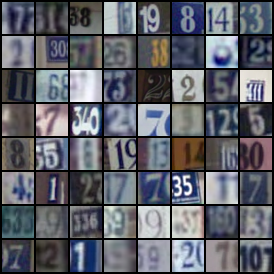

In [ ]:
from IPython.display import Image

#print(datasetloader)
# Plot some training images
batch = next(iter(train_loader))
print(batch[0].shape)
sample = batch[0]
vutils.save_image(sample, f'train.png', normalize=True, value_range=(-1, 1))
Image('train.png')

Initialize generator/discriminator weights

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator(z_dim=z_dim).to(device)
generator.apply(weights_init)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
critic = Critic().to(device)
critic.apply(weights_init)

Critic(
  (x): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [ ]:
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(beta1, beta2))
optim_generator = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
train_iter = iter(train_loader)
valid_iter = iter(valid_loader)
test_iter = iter(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# COMPLETE TRAINING PROCEDURE
for i in tqdm(range(n_iter)):

	generator.train()
	critic.train()

	for _ in range(n_critic_updates):
		try:
			real = next(train_iter)[0].to(device)
		except Exception:
			train_iter = iter(train_loader)
			real = next(train_iter)[0].to(device)
		#####
		# train the critic model here
		#####

		noise = torch.randn(real.shape[0], z_dim, 1, 1).to(device)
		fake = generator(noise).to(device)

		gp = lp_reg(real, fake, critic)
		loss_critic = (
			-vf_wasserstein_distance(real,fake,critic) + lp_coeff * gp
		)

		critic.zero_grad()
		loss_critic.mean().backward(retain_graph=True)
		optim_critic.step()


	#####
	# train the generator model here
	#####

	gen_fake = critic(fake).view(-1)
	loss_gen = -torch.mean(gen_fake)
	generator.zero_grad()
	loss_gen.backward()
	optim_generator.step()

	# Save sample images
	if i % 10000 == 0:
		z = torch.randn(64, z_dim, device=device)
		imgs = generator(z)
		vutils.save_image(imgs, f'imgs_{i}.png', normalize=True, value_range=(-1, 1))


# COMPLETE QUALITATIVE EVALUATION


  0%|          | 228/60000 [00:31<2:17:20,  7.25it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 60000/60000 [2:19:32<00:00,  7.17it/s]


In [ ]:
z = torch.randn(64, z_dim, device=device)
imgs = generator(z)
vutils.save_image(imgs, f'imgs_60000.png', normalize=True, value_range=(-1, 1))

Insert Save Folder

In [ ]:
save_folder =  "/content/gdrive/MyDrive/Master_UdeM/IFT-6135_H2022/IFT6135_Programming/assignment3/GANs/" #@param {type:"string"}

Save models : generator, critic

In [ ]:
torch.save(generator, save_folder+"generator.pt")
torch.save(critic, save_folder+"critic.pt")

*Load* the model

In [ ]:
generator = torch.load(save_folder+"generator.pt")
critic = torch.load(save_folder+"critic.pt")

## Question 2.3

In [ ]:
torch.random.seed()

15154418665048900146

In [ ]:
z_dim

100

In [ ]:
z_init = torch.randn(1, z_dim)
eps = 0.01
z_init = z_init
batch = 64

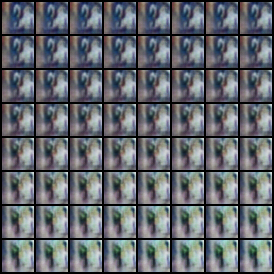

In [ ]:
#1st attemp
zs = torch.tensor([]).to(device)
zi = z_init.to(device)

for i in range(64):
  zs = torch.cat((zs, zi))
  zi = zi + eps

imgs = generator(zs)
vutils.save_image(imgs, f'disentangled.png', normalize=True, value_range=(-1, 1))

Image('disentangled.png')

#### 2.3 And 2.4

0 0
1 10
2 20
3 30
4 40
5 50
6 60
7 70
8 80
9 90


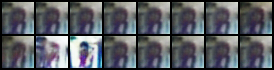

In [ ]:
#second attempt
baseline_z  = torch.randn(1,z_dim)
baseline_z
epsilon = 0.01
device = "cuda" if torch.cuda.is_available else "cpu"
#get 10 copies of perturbation
baseline_z = torch.repeat_interleave(baseline_z,16,dim=0).to(device)
for row,dim in enumerate(range(0,100,10)):
  print(row,dim)
  baseline_z[row+1][dim] +=epsilon
  epsilon+=epsilon

with torch.no_grad():
  im = generator(baseline_z)
  vutils.save_image(im, f'disentangled.png', normalize=True, value_range=(-1, 1))
Image('disentangled.png')

2.4

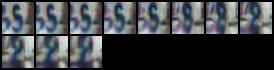

In [ ]:
# eps = torch.randn(1, 100, device=device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# generator = torch.load("/content/assignment/gan_results/iter_49000/model_Generator_Final.pth")
#generator = torch.load("/content/assignment/gan_results/model_Generator_Final.pth")

nb_img = 1
z_0 = torch.randn(nb_img, 100,  device=device) #+ eps
z_1 = torch.randn(nb_img, 100,  device=device) #+ eps

rng=np.arange(0, 1.1, 0.1)

imgs = torch.empty(size=(len(rng),3,32,32))
for idx, alpha in enumerate(rng):
  z_prime_alpha = alpha*z_0 + (1 - alpha)*z_1
  im = generator(z_prime_alpha)
  imgs[idx] = im.squeeze()
vutils.save_image(imgs, f'2_4_a.png', normalize=True, value_range=(-1, 1))



################################################

x_0 = generator(z_0)
x_1 = generator(z_1)

imgs = torch.empty(size=(len(rng),3,32,32))
for idx, alpha in enumerate(rng):
  im = alpha*x_0 + (1 - alpha)*x_1
  imgs[idx] = im.squeeze()
vutils.save_image(imgs, f'2_4_b.png', normalize=True, value_range=(-1, 1))

Image('2_4_a.png')

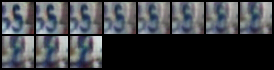

In [ ]:
Image('2_4_b.png')